In [394]:
import astropy.coordinates as coord
from astropy.coordinates.angle_utilities import angular_separation
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import fitsio

from astropy.stats import median_absolute_deviation as MAD
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import KernelDensity
from pyia import GaiaData
from tqdm.notebook import tqdm

coord.galactocentric_frame_defaults.set('v4.0')
galcen_frame = coord.Galactocentric()

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from gala.mpl_style import *

In [104]:
mw = gp.BovyMWPotential2014()

In [436]:
import pandas as pd

def load_data(filename, ext=1, nrows=None, offset=0):
    hdr = fitsio.read_header(filename, ext=ext)
    N = hdr['NAXIS2']
    
    columns = ['R', 'phi', 'z', 'vR', 'vT', 'vz']
    if nrows is not None:
        idx = np.arange(offset, offset + nrows)
        data = fitsio.read(filename, rows=idx, ext=ext, columns=columns)
    else:
        data = fitsio.read(filename, ext=ext, columns=columns)
        
    tmp_t = fitsio.read(filename, ext=ext, columns=['t'], rows=N-1)
    
    # simulation units
    ro = 8. * u.kpc
    vo = 220. * u.km/u.s

    rep = coord.CylindricalRepresentation(
        rho=data['R'] * ro, 
        phi=(data['phi'] + np.pi) * u.rad,
        z=data['z'] * ro)
    dif = coord.CylindricalDifferential(
        d_rho=data['vR'] * vo,
        d_phi=((-data['vT']*vo) / (data['R']*ro)).to(u.rad/u.Gyr, u.dimensionless_angles()),
        d_z=data['vz'] * vo
    )
    rep = rep.with_differentials(dif)
    t = tmp_t['t'][0] * 0.033857163133384896 * u.Gyr
    
    w = gd.PhaseSpacePosition(rep).cartesian
    icrs = w.to_coord_frame(coord.ICRS, galactocentric_frame=galcen_frame)
    gal = w.to_coord_frame(coord.Galactic, galactocentric_frame=galcen_frame)
    
    df = pd.DataFrame({
        # Cylindrical
        'R': rep.rho.to_value(u.kpc),
        'phi': rep.phi.to_value(u.rad),
        'z': rep.z.to_value(u.kpc),
        'v_R': dif.d_rho.to_value(u.km/u.s),
        'v_phi': (-data['vT']*vo).to_value(u.km/u.s),
        'v_z': dif.d_z.to_value(u.km/u.s),
        # Cartesian
        'x': w.x.to_value(u.kpc),
        'y': w.y.to_value(u.kpc),
        'z': w.z.to_value(u.kpc),
        'v_x': w.v_x.to_value(u.km/u.s),
        'v_y': w.v_y.to_value(u.km/u.s),
        'v_z': w.v_z.to_value(u.km/u.s),
        # Observed
        'ra': icrs.ra.degree,
        'dec': icrs.dec.degree,
        'distance': icrs.distance.to_value(u.kpc),
        'l': gal.l.wrap_at(360*u.deg).degree,
        'b': gal.b.degree
    })
    
    return t, df.loc[np.isfinite(df.ra) & (df.ra != 0.)]

In [437]:
filename = '/mnt/home/jhunt/ceph/TPBubs/data/output/Sgr5/full/Sgr5_99.fits'
t, df = load_data(filename, nrows=10_000_000, offset=200)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [438]:
vcirc = mw.circular_velocity(
    np.array([df['x'].values, 
              df['y'].values,
              df['z'].values])).to_value(u.km/u.s)
Rg = df.R * -df.v_phi / vcirc

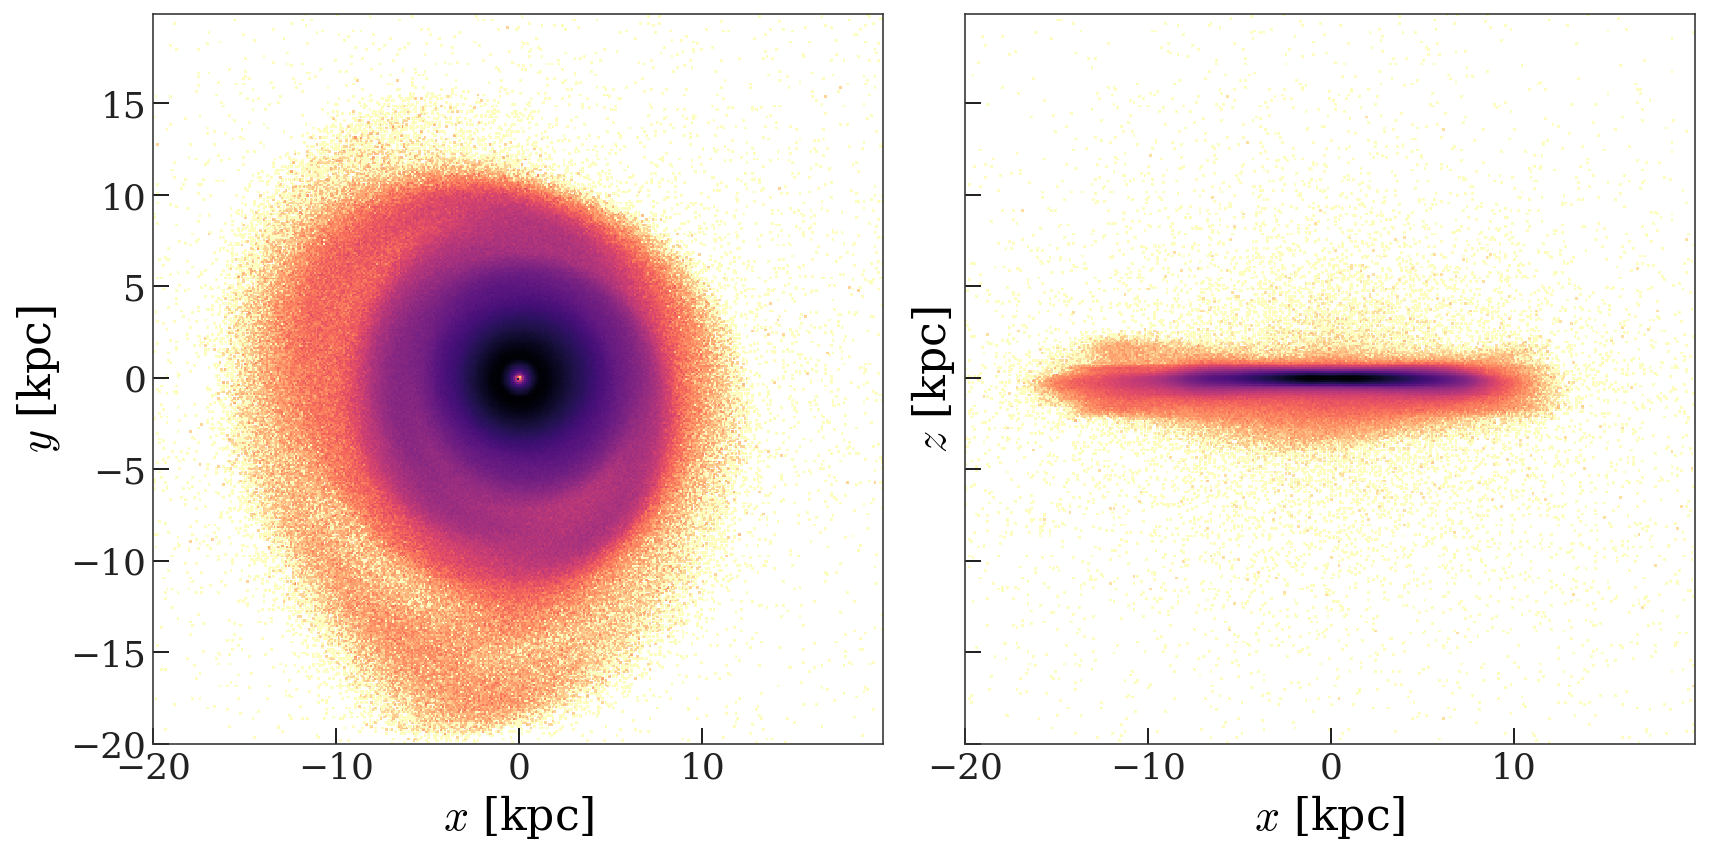

In [415]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                       sharex=True, sharey=True)

ax = axes[0]
ax.hist2d(
    df.x, df.y,
    bins=np.arange(-20, 20, 0.1),
    norm=mpl.colors.LogNorm(),
    cmap='magma_r')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$y$ [kpc]')

ax = axes[1]
ax.hist2d(
    df.x, df.z,
    bins=np.arange(-20, 20, 0.1),
    norm=mpl.colors.LogNorm(),
    cmap='magma_r')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

fig.tight_layout()

Text(0, 0.5, '$z$ [kpc]')

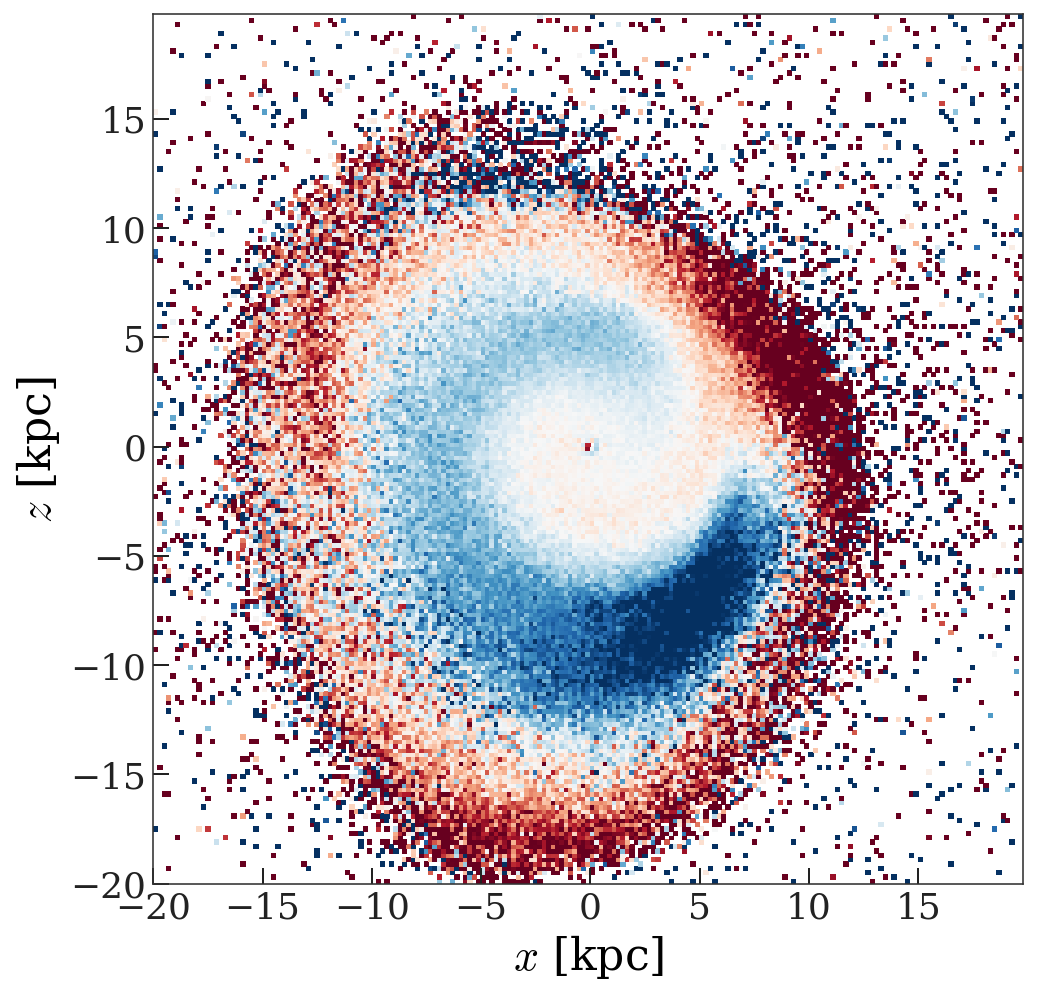

In [419]:
stat = binned_statistic_2d(
    df.x, df.y, df.v_z,
    bins=np.arange(-20, 20, 0.2))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T,
    vmin=-10, vmax=10, cmap='RdBu')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [kpc]')
ax.set_ylabel('$z$ [kpc]')

### Data/sim comparison

- Loop over APOGEE fields in RGB sample
- Select sim particles to match distance distribution along each LOS

In [271]:
g = GaiaData('../data/APOGEE-Alvaro-EDR3-RGB.fits')
g.data['FIELD'] = g.data['FIELD'].astype(str)

In [276]:
tmp_df = g.data['ra', 'dec', 'FIELD'].to_pandas()
for i, name in enumerate('xyz'):
    tmp_df[name] = g.get_skycoord(distance=False).cartesian.xyz.value[i]

tmp = tmp_df.groupby('FIELD').mean()
tmp_std = tmp_df.groupby('FIELD').std()
xyz_std = (np.sqrt(tmp_std['x']**2 + 
                   tmp_std['y']**2 + 
                   tmp_std['z']**2).values * u.rad).to_value(u.deg)
assert np.all(xyz_std[np.isfinite(xyz_std)] < 1.5)

mean_fields = at.Table()
mean_fields['FIELD'] = tmp.index.values.astype(str)

fieldcen = coord.CartesianRepresentation(
    tmp['x'].values, 
    tmp['y'].values, 
    tmp['z'].values).represent_as(coord.SphericalRepresentation)
mean_fields['ra'] = fieldcen.lon.degree
mean_fields['dec'] = fieldcen.lat.degree
mean_fields = mean_fields[np.isfinite(mean_fields['dec'])]

mean_fields_c = coord.SkyCoord(
    mean_fields['ra'], mean_fields['dec'], unit=u.deg)

len(mean_fields)

1995

In [382]:
from sklearn.mixture import GaussianMixture

In [383]:
global_weights = np.zeros(len(df))

In [420]:
apogee_field_radius = 3 * u.deg
# apogee_field_radius = 5 * u.deg  # HACK

df_l_mask = (df.l > 90) & (df.l < 270)
field_l_mask = ((mean_fields_c.galactic.l > 90*u.deg) & 
                (mean_fields_c.galactic.l < 270*u.deg))

for i, (field, field_c) in tqdm(enumerate(
        zip(mean_fields['FIELD'][field_l_mask], 
            mean_fields_c[field_l_mask])), total=field_l_mask.sum()):
    field_mask = g.FIELD == field
    
    sep = angular_separation(field_c.ra, field_c.dec, 
                             df.ra.values*u.deg, df.dec.values*u.deg)
    sep_mask = (sep < apogee_field_radius) & df_l_mask
    
    if sep_mask.sum() < field_mask.sum():
        continue
        
    sim_field_dists = df.distance.values[sep_mask]
    
    # Target distribution:
    bw = 0.5
    kernel = 'epanechnikov'
    kde = KernelDensity(bandwidth=bw, kernel=kernel).fit(
        g.D2_med[field_mask].reshape(-1, 1))
    kde_lnprob = kde.score_samples(
        sim_field_dists.reshape(-1, 1))
    
    # Simulation distribution:
#     bg_kde = KernelDensity(bandwidth=bw, 
#                            kernel=kernel)
#     bg_kde.fit(sim_field_dists.reshape(-1, 1))
#     bg_lnprob = bg_kde.score_samples(
#         sim_field_dists.reshape(-1, 1))
    
    gmm = GaussianMixture(n_components=7)
    gmm.fit(sim_field_dists.reshape(-1, 1))
    bg_lnprob = gmm.score_samples(
        sim_field_dists.reshape(-1, 1))
    
    weights = np.exp(kde_lnprob - bg_lnprob)
    global_weights[sep_mask] = weights

In [425]:
(global_weights > 0).sum()

77256

(-90.0, 90.0)

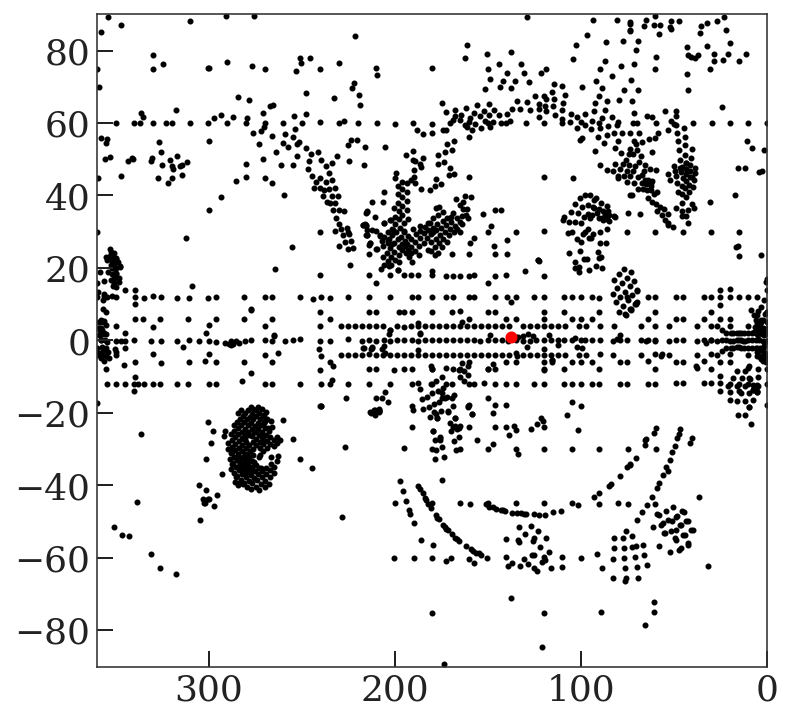

In [427]:
plt.scatter(mean_fields_c.galactic.l.degree,
            mean_fields_c.galactic.b.degree, s=4)
plt.scatter(field_c.galactic.l.degree,
            field_c.galactic.b.degree,
            color='r')
plt.xlim(360, 0)
plt.ylim(-90, 90)

(-90.0, 90.0)

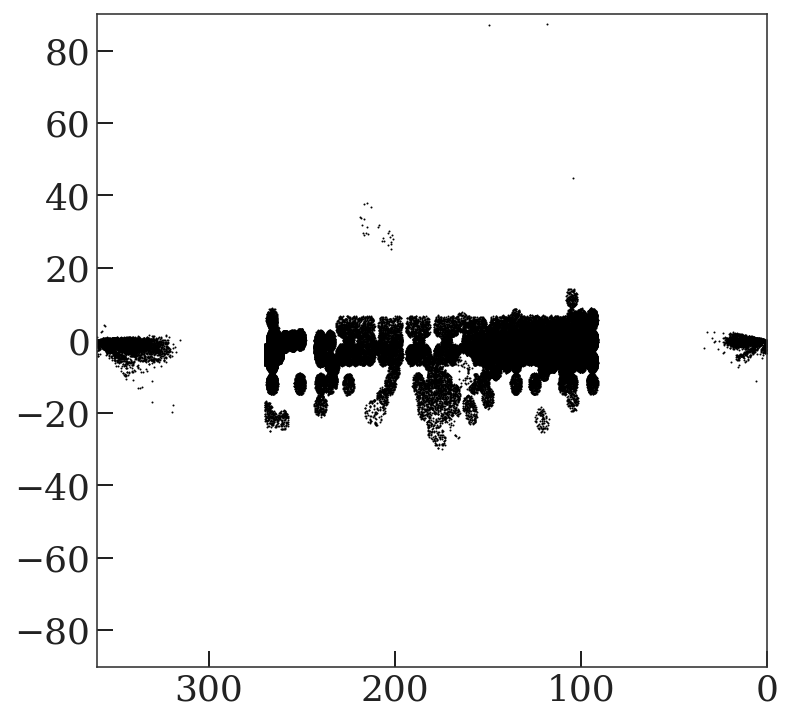

In [429]:
plt.plot(df.l[global_weights>0],
         df.b[global_weights>0],
         marker='o', ls='none', ms=1)
plt.xlim(360, 0)
plt.ylim(-90, 90)

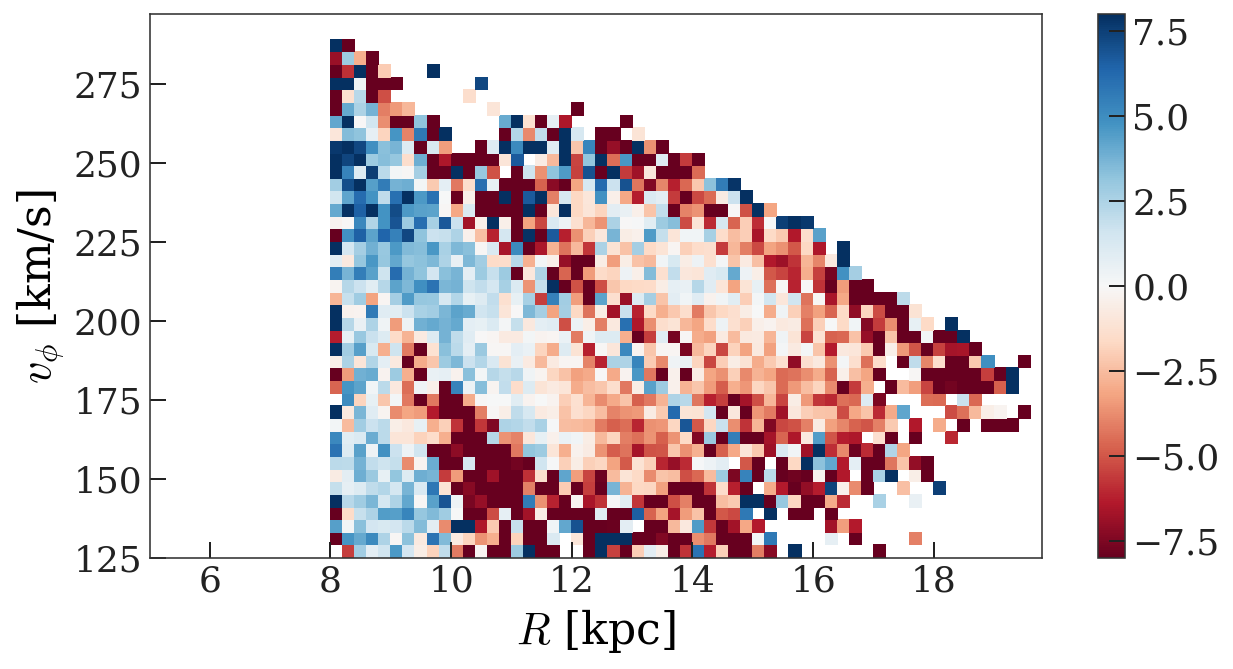

In [441]:
stat = binned_statistic_2d(df.R.values[global_weights > 0], 
                           -df.v_phi.values[global_weights > 0],
                           df.v_z.values[global_weights > 0],
                           bins=(np.arange(5, 20, 0.2),
                                 np.arange(125, 300, 4)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cs = ax.pcolormesh(
    stat.x_edge, stat.y_edge, stat.statistic.T,
    vmin=-8, vmax=8, 
    cmap='RdBu')
fig.colorbar(cs)

ax.set_xlabel('$R$ [kpc]')
ax.set_ylabel(r'$v_\phi$ [km/s]')

fig.set_facecolor('w')